In [1]:
%matplotlib ipympl
# basic imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# setting path for mv_python_utils
sys.path.append('../helper_functions')
from mv_python_utils import loadmat_struct

# define fname
fname = '../STRG_computed_features/alphaSPADE/test.mat'

# load stuff
mat_content = loadmat_struct(fname)
F = mat_content['outdat']

In [2]:
# import all packages needed for classification
from sklearn.svm import SVC
# from sklearn.metrics import balanced_accuracy_score # not needed now, called internally from pipeline object
# functions for PCA
from sklearn.decomposition import PCA
# pipeline definer
from sklearn.pipeline import Pipeline
# scaler
from sklearn.preprocessing import RobustScaler
# for inserting tanh in pipeline
from sklearn.preprocessing import FunctionTransformer
# crossvalidation
from sklearn.model_selection import cross_val_score

import copy

# define the pipeline to be used
class_pipeline = Pipeline([('scaler', RobustScaler()),
                           ('squeezer', FunctionTransformer(np.tanh)),
                           ('std_PCA', PCA(n_components=.9, svd_solver='full')),
                           ('SVM', SVC(C=10, random_state=42))
                           ])


In [14]:
# define function for time resolved classification

# note: use PCA at every timepoint, but keep track of how many components have been selected. 
# My guess is that with event related activity, with increased synch, a lower number of components is retained,
# facilitating the classifier.

# preamble
mask_evs = F['trialinfo'][:,1]>=10 # erase catch, fttb
Y = F['trialinfo'][mask_evs,1] # 6 classes classification
y_H_M = (Y==11) | (Y==22)
randY = copy.deepcopy(y_H_M)
np.random.shuffle(randY)

cv_fold = 5;

dict_accs = {}
for ifeat in F['single_feats'].keys():

    ntpoints = F['single_feats'][ifeat].shape[1]    
    dict_accs[ifeat] = []

    for iT in range(ntpoints):

        X = F['single_feats'][ifeat][:, iT, mask_evs].T

        acc = cross_val_score(class_pipeline, X, y_H_M, cv=cv_fold, 
                              scoring='balanced_accuracy').mean()
        rand_acc = cross_val_score(class_pipeline, X, randY, cv=cv_fold, 
                                    scoring='balanced_accuracy').mean()

        dict_accs[ifeat].append(acc-rand_acc)
    
        print(ifeat + ': ' + str(iT) + '/' + str(ntpoints))
    
    


MCL: 42/176
MCL: 42/176
MCL: 42/176
MCL: 42/176
MCL: 42/176
MCL: 42/176
MCL: 42/176
MCL: 42/176
MCL: 42/176
MCL: 42/176
std: 42/176
std: 42/176
std: 42/176
std: 42/176
std: 42/176
std: 42/176
std: 42/176
std: 42/176
std: 42/176
std: 42/176
mean: 42/176
mean: 42/176
mean: 42/176
mean: 42/176
mean: 42/176
mean: 42/176
mean: 42/176
mean: 42/176
mean: 42/176
mean: 42/176


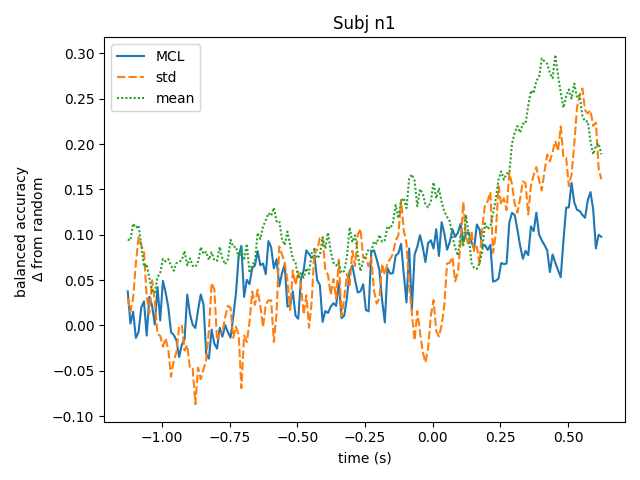

In [16]:

dict_accs['time (s)'] = F['time_winCENter']

DF_accs = pd.DataFrame.from_dict(dict_accs)
DF_accs = DF_accs.set_index('time (s)')

plt.figure()
sns.lineplot(data=DF_accs)
# DF_accs.plot()

plt.ylabel('balanced accuracy \n$\Delta$ from random')

plt.title('Subj n1')
plt.tight_layout()